In [1]:
%matplotlib inline
# Load necessary modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm


logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/'

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/35927/status,
Dashboard: /proxy/35927/status,Workers: 7
Total threads: 28,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44141,Workers: 7
Dashboard: /proxy/35927/status,Total threads: 28
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:38985,Total threads: 4
Dashboard: /proxy/44385/status,Memory: 143.87 GiB
Nanny: tcp://127.0.0.1:45647,


In [3]:
chunk = {'yu_ocean':52, 'xu_ocean':1200}
# Load the along-slope velocity field
u_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Binned_ASC_speed/OM2_IAF/Binned_Antarctic_slope_contour_1km_velocities*')
# Load CSHT field
CSHT_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_z/*')

In [4]:
# Average U_along into mean, seasonal, monthly and annual fields

u_along_da_mean = u_along.mean('time').u_along_contour_binned
u_along_da_seasonal = u_along.groupby('time.month').mean('time').u_along_contour_binned
u_along_da_annual = u_along.groupby('time.year').mean('time').u_along_contour_binned
u_along_da_monthly = u_along.resample(time='1M').mean().u_along_contour_binned

u_along_da_mean.load()
u_along_da_seasonal.load()
u_along_da_annual.load()
u_along_da_monthly.load()

<xarray.DataArray 'u_along_contour_binned' (time: 732, st_ocean: 75,
                                            lon_bin_midpoints: 1428)> Size: 627MB
array([[[-0.02359511, -0.02475564, -0.02657239, ..., -0.0204653 ,
         -0.02053152, -0.02350026],
        [-0.01865366, -0.01979311, -0.02162974, ..., -0.01303114,
         -0.01375674, -0.01694079],
        [-0.01603528, -0.01716227, -0.01901062, ..., -0.00900011,
         -0.0100713 , -0.01337444],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.06889385, -0.06873107, -0.06851074, ..., -0.02077237,
         -0.02169113, -0.02693162],
        [-0.06278588, -0.06240495, -0.06204439, ..., -0.01473967,
         -0.01655271, -0.02205193],
        [-0.05906674, -0.05856833, -0.05814252, ..., -0.01109173,
         -0.01338399, -0.0190114 ],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.0376156 , -0.03683981, -0.03611625, ..., -0.03758969,
         -0.03398371, -0.03630787],
        [-0.03121829, -0.0303874 , -0.02965705, ..., -0.0294911 ,
         -0.02702347, -0.02966545],
        [-0.02686711, -0.02600385, -0.02527127, ..., -0.02429345,
         -0.0225731 , -0.02540491],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * st_ocean           (st_ocean) float64 600B 0.5413 1.681 ... 5.709e+03
  * lon_bin_midpoints  (lon_bin_midpoints) float64 11kB -278.5 -278.2 ... 78.25
  * time               (time) datetime64[ns] 6kB 1958-01-31 ... 2018-12-31

In [5]:
# get time-mean regimes mask

ds = xr.open_dataset('/g/data/v45/txs156/ASC_classification/clustering_mask_time_mean.nc')
regime_mask = ds.regimes_mask
ds.close()
regime_mask.load()

<xarray.DataArray 'regimes_mask' (regime: 3, lon: 1428)> Size: 34kB
array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * regime   (regime) <U7 84B 'Surface' 'Reverse' 'Deep'
  * lon      (lon) float64 11kB -278.5 -278.2 -278.0 -277.8 ... 77.75 78.0 78.25

In [6]:
# # first rename u_along_da_mean/u_along_da_annuak longitude dimension
# # from "lon_bin_midpoints" to "lon" (to match masks)

u_along_da_mean = u_along_da_mean.rename({'lon_bin_midpoints': 'lon'})
u_along_da_annual = u_along_da_annual.rename({'lon_bin_midpoints': 'lon'})


In [7]:
# annual avg whole IAF
u_along_da_mean_masked = u_along_da_mean.expand_dims(dim={"regime": 3})
u_along_da_mean_masked = u_along_da_mean_masked*regime_mask

In [8]:
# read statistics calculated in longitudinal bins:
files_path = '/g/data/hh5/tmp/access-om/fbd581/ASC_project/statisctic_lonbin/'


In [9]:
# 20deg (original - missing one bin!)
ds = xr.open_dataset(files_path + 'slope_annual_20degBins.nc')
slope_annual_20deg = ds.slope_annual
depth_20deg = ds.depth
ds.close()
ds = xr.open_dataset(files_path + 'slope_all_20degBins.nc')
slope_all_20deg = ds.slope_all
ds.close()
ds = xr.open_dataset(files_path + 'slope_clima_20degBins.nc')
slope_clima_20deg = ds.slope_clima
ds.close()
ds = xr.open_dataset(files_path + 'stderr_annual_20degBins.nc')
stderr_annual_20deg = ds.stderr_annual
ds.close()
ds = xr.open_dataset(files_path + 'stderr_all_20degBins.nc')
stderr_all_20deg = ds.stderr_all
ds.close()
ds = xr.open_dataset(files_path + 'stderr_clima_20degBins.nc')
stderr_clima_20deg = ds.stderr_clima
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_annual_20degBins.nc')
r_sq_annual_20deg = ds.r_sq_annual
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_all_20degBins.nc')
r_sq_all_20deg = ds.r_sq_all
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_clima_20degBins.nc')
r_sq_clima_20deg = ds.r_sq_clim
ds.close()


In [10]:
# 20deg Test (1)
# ds = xr.open_dataset(files_path + 'slope_annual_20degBins_t1.nc')
# slope_annual_20deg = ds.slope_annual
# depth_20deg = ds.depth
# ds.close()
# ds = xr.open_dataset(files_path + 'slope_all_20degBins_t1.nc')
# slope_all_20deg = ds.slope_all
# ds.close()
# ds = xr.open_dataset(files_path + 'slope_clima_20degBins_t1.nc')
# slope_clima_20deg = ds.slope_clima
# ds.close()
# ds = xr.open_dataset(files_path + 'stderr_annual_20degBins_t1.nc')
# stderr_annual_20deg = ds.stderr_annual
# ds.close()
# ds = xr.open_dataset(files_path + 'stderr_all_20degBins_t1.nc')
# stderr_all_20deg = ds.stderr_all
# ds.close()
# ds = xr.open_dataset(files_path + 'stderr_clima_20degBins_t1.nc')
# stderr_clima_20deg = ds.stderr_clima
# ds.close()
# ds = xr.open_dataset(files_path + 'r_sq_annual_20degBins_t1.nc')
# r_sq_annual_20deg = ds.r_sq_annual
# ds.close()
# ds = xr.open_dataset(files_path + 'r_sq_all_20degBins_t1.nc')
# r_sq_all_20deg = ds.r_sq_all
# ds.close()
# ds = xr.open_dataset(files_path + 'r_sq_clima_20degBins_t1.nc')
# r_sq_clima_20deg = ds.r_sq_clim
# ds.close()


In [11]:
# # 20deg Test (2)
# ds = xr.open_dataset(files_path + 'slope_annual_20degBins_t2.nc')
# slope_annual_20deg = ds.slope_annual
# depth_20deg = ds.depth
# ds.close()
# ds = xr.open_dataset(files_path + 'slope_all_20degBins_t2.nc')
# slope_all_20deg = ds.slope_all
# ds.close()
# ds = xr.open_dataset(files_path + 'slope_clima_20degBins_t2.nc')
# slope_clima_20deg = ds.slope_clima
# ds.close()
# ds = xr.open_dataset(files_path + 'stderr_annual_20degBins_t2.nc')
# stderr_annual_20deg = ds.stderr_annual
# ds.close()
# ds = xr.open_dataset(files_path + 'stderr_all_20degBins_t2.nc')
# stderr_all_20deg = ds.stderr_all
# ds.close()
# ds = xr.open_dataset(files_path + 'stderr_clima_20degBins_t2.nc')
# stderr_clima_20deg = ds.stderr_clima
# ds.close()
# ds = xr.open_dataset(files_path + 'r_sq_annual_20degBins_t2.nc')
# r_sq_annual_20deg = ds.r_sq_annual
# ds.close()
# ds = xr.open_dataset(files_path + 'r_sq_all_20degBins_t2.nc')
# r_sq_all_20deg = ds.r_sq_all
# ds.close()
# ds = xr.open_dataset(files_path + 'r_sq_clima_20degBins_t2.nc')
# r_sq_clima_20deg = ds.r_sq_clim
# ds.close()


### calculate weights for weight-average statistics:

find how many points in each bin for each regime

Choose the bin edges below to uncomment depending on the test load above:

In [12]:
# -------------------------------------------------------------------------------------------------------------------

# 1) bin edges b/w -280:80
#    - weight 1st/last bins accordingly (i.e., max 74 pts, not 80 as all other bins)
# lon_bin=20
# bin_edges = np.arange(-280, u_along_da_mean_masked.lon[-1]+(lon_bin/2), lon_bin)
# lon_bin_mid = np.arange((bin_edges[0]+(lon_bin/2)),(bin_edges[-1]+(lon_bin/2)),lon_bin) # for 20-deg bins


# # 2) bin edges b/w -278.5:81.5
#    - appending first 12 ponts in the last bin, so weight is uniform for all bins:
# lon_bin=20
# bin_edges = np.arange(u_along_da_mean_masked.lon[0], u_along_da_mean_masked.lon[-1]+(lon_bin/2), lon_bin)
# lon_bin_mid = np.arange((bin_edges[0]+(lon_bin/2)),(bin_edges[-1]+(lon_bin/2)),lon_bin) # for 20-deg bins


# 3) bin edges b/w -278.5:78.5 (missing one bin, here just for the legacy)
#    - weight last bin accordingly (i.e., max 74 pts, not 80 as all other bins)
lon_bin=20
bin_edges = np.arange(u_along_da_mean_masked.lon[0], u_along_da_mean_masked.lon[-1], lon_bin)
lon_bin_mid = np.arange((bin_edges[0]+(lon_bin/2)),(bin_edges[-1]+(lon_bin/2)),lon_bin) # for 20-deg bins

# -------------------------------------------------------------------------------------------------------------------
print(bin_edges)

[-278.5 -258.5 -238.5 -218.5 -198.5 -178.5 -158.5 -138.5 -118.5  -98.5
  -78.5  -58.5  -38.5  -18.5    1.5   21.5   41.5   61.5]


In [13]:
## If test 2, switch from u_along_da_mean_masked to u_along_da_mean_masked_halo:

# newlon = np.concatenate((u_along_da_mean_masked.lon.values,np.arange(78.5,81.5,.25)), axis=0)
# longfix = xr.DataArray(newlon, coords={'lon': newlon},dims=['lon'])

# u_along_da_mean_masked_halo = xr.concat([u_along_da_mean_masked,
#                                         u_along_da_mean_masked.isel(lon=slice(0,12))],
#                                         dim='lon')
# u_along_da_mean_masked_halo['lon'] = longfix

# regime_mask_halo = xr.concat([regime_mask,regime_mask.isel(lon=slice(0,12))],dim='lon')
# longfix = xr.DataArray(newlon, coords={'lon': newlon},dims=['lon'])
# regime_mask_halo['lon'] = longfix


In [16]:
u_along_da_mean_masked.lon

<xarray.DataArray 'lon' (lon: 1428)> Size: 11kB
array([-278.5 , -278.25, -278.  , ...,   77.75,   78.  ,   78.25])
Coordinates:
  * lon      (lon) float64 11kB -278.5 -278.2 -278.0 -277.8 ... 77.75 78.0 78.25

In [17]:
# count number of grid-points:

# print(bin_edges.shape)
weight_20deg = np.empty((len(lon_bin_mid),3))

for rr in range(0,3):
    for aa in range(0,len(lon_bin_mid)):
        lower_lon = bin_edges[aa]
        upper_lon = bin_edges[aa+1]

        # for test 1/3:
        pts_w_range = u_along_da_mean_masked.lon[(u_along_da_mean_masked.isel(regime=rr).lon*regime_mask.isel(regime=rr) >= lower_lon) 
                                                    & (u_along_da_mean_masked.isel(regime=rr).lon*regime_mask.isel(regime=rr) < upper_lon)]
        # for test 2:
        # pts_w_range = u_along_da_mean_masked_halo.lon[(u_along_da_mean_masked_halo.isel(regime=rr).lon*regime_mask_halo.isel(regime=rr) >= lower_lon) 
        #                                             & (u_along_da_mean_masked_halo.isel(regime=rr).lon*regime_mask_halo.isel(regime=rr) < upper_lon)]
        
        npts = len(pts_w_range)

        weight_20deg[aa,rr] = npts
        del pts_w_range, npts
    
 

In [19]:
len(lon_bin_mid)

17

In [20]:
# adjust weigth array to be proportional to max no of gripdpoint possible:
weight_20deg_pct = np.divide(weight_20deg,80) # 80 is max. n of points within a 20deg bin

# test 1) replace the 1st/last bin max count:
# weight_20deg_pct[-1,:] = np.divide(weight_20deg[-1,:], 74)
# weight_20deg_pct[0,:] = np.divide(weight_20deg[-1,:], 74)
# weight_20deg_sum = np.nansum(weight_20deg_pct,0)

# test 2) don't do nothing:
# weight_20deg_sum = np.nansum(weight_20deg_pct,0)

# test 3) don't do nothing:
weight_20deg_sum = np.nansum(weight_20deg_pct,0)


In [21]:
weight_20deg_pct

array([[1.    , 0.    , 0.    ],
       [1.    , 0.    , 0.    ],
       [0.4875, 0.    , 0.5125],
       [0.4875, 0.    , 0.5125],
       [0.375 , 0.1   , 0.525 ],
       [0.85  , 0.    , 0.15  ],
       [1.    , 0.    , 0.    ],
       [1.    , 0.    , 0.    ],
       [0.35  , 0.65  , 0.    ],
       [0.0375, 0.9625, 0.    ],
       [0.    , 1.    , 0.    ],
       [0.    , 0.05  , 0.95  ],
       [0.6875, 0.    , 0.3125],
       [1.    , 0.    , 0.    ],
       [1.    , 0.    , 0.    ],
       [1.    , 0.    , 0.    ],
       [0.75  , 0.    , 0.25  ]])

In [22]:
# depth4plot = depth_20deg

slope_annual_wavg_20deg = np.divide(np.nansum(slope_annual_20deg*weight_20deg_pct, axis=1),weight_20deg_sum)
slope_all_wavg_20deg = np.divide(np.nansum(slope_all_20deg*weight_20deg_pct, axis=1),weight_20deg_sum)
slope_clima_wavg_20deg = np.divide(np.nansum(slope_clima_20deg*weight_20deg_pct, axis=1),weight_20deg_sum)

stderr_annual_wavg_20deg = np.divide(np.nansum(stderr_annual_20deg*weight_20deg_pct, axis=1),weight_20deg_sum)
stderr_all_wavg_20deg = np.divide(np.nansum(stderr_all_20deg*weight_20deg_pct, axis=1),weight_20deg_sum)
stderr_clima_wavg_20deg = np.divide(np.nansum(stderr_clima_20deg*weight_20deg_pct, axis=1),weight_20deg_sum)

r_sq_annual_wavg_20deg = np.divide(np.nansum(r_sq_annual_20deg*weight_20deg_pct, axis=1),weight_20deg_sum)
r_sq_all_wavg_20deg = np.divide(np.nansum(r_sq_all_20deg*weight_20deg_pct, axis=1),weight_20deg_sum)
r_sq_clima_wavg_20deg = np.divide(np.nansum(r_sq_clima_20deg*weight_20deg_pct, axis=1),weight_20deg_sum)

# average r^2 800 and bottom;

r_sq_annual_plot_20deg = np.divide(np.nansum(r_sq_annual_20deg[-7:,:,:]*weight_20deg_pct, axis=0),weight_20deg_sum)
r_sq_all_plot_20deg = np.divide(np.nansum(r_sq_all_20deg[-7:,:,:]*weight_20deg_pct, axis=0),weight_20deg_sum)
r_sq_clima_plot_20deg = np.divide(np.nansum(r_sq_clima_20deg[-7:,:,:]*weight_20deg_pct, axis=0),weight_20deg_sum)

(50, 3) (50, 3)


Text(0.5, 1.0, 'Test 3')

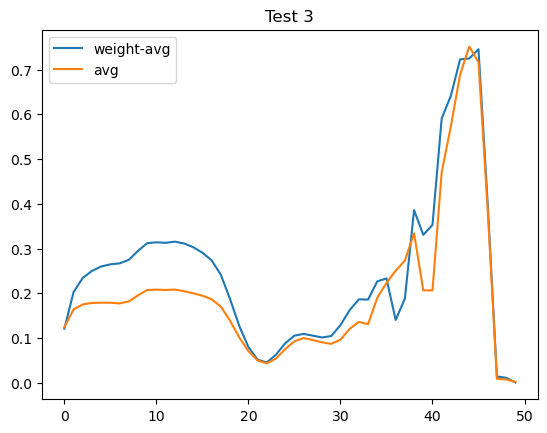

In [24]:
# testing plot r_sq with x without weighting:

r_sq_annual_20deg_wei = np.divide(np.nansum(r_sq_annual_20deg*weight_20deg_pct, axis=1),weight_20deg_sum)
r_sq_annual_20deg_avg = np.nanmean(r_sq_annual_20deg, axis=1)

print(r_sq_annual_20deg_wei.shape, r_sq_annual_20deg_avg.shape)
plt.plot(r_sq_annual_20deg_wei[:,1],label='weight-avg')
plt.plot(r_sq_annual_20deg_avg[:,1],label='avg')
plt.legend()
# plt.title('Test 1')
# plt.title('Test 2')
plt.title('Test 3')


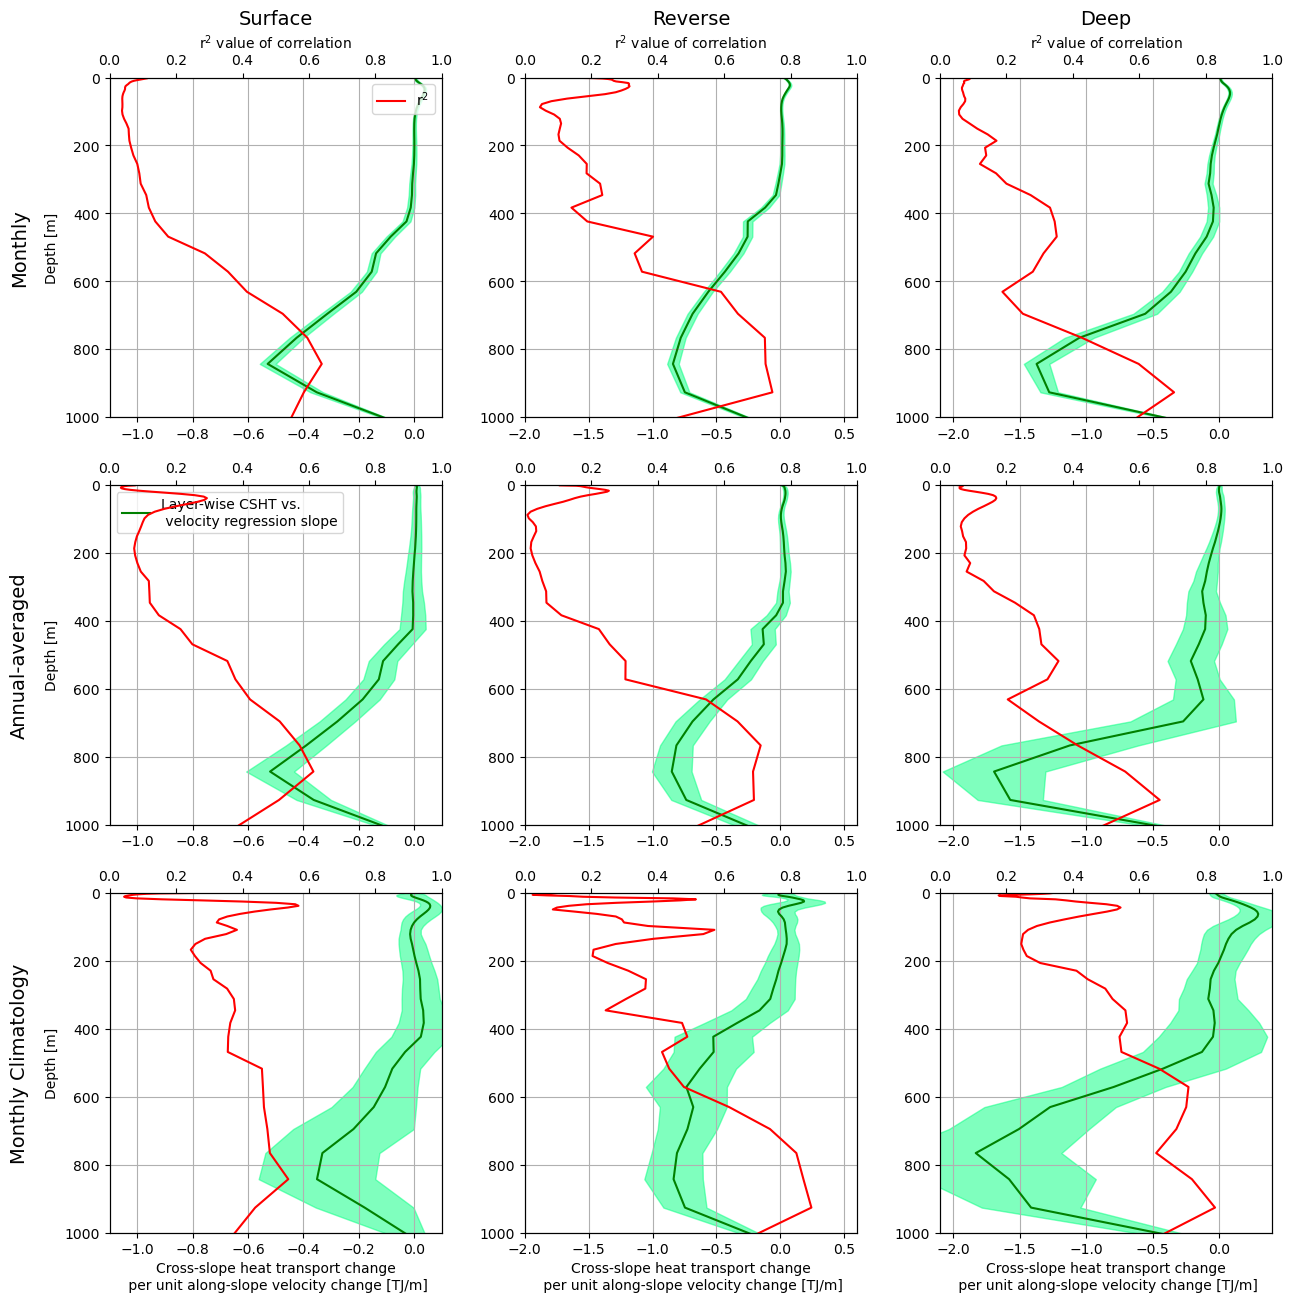

In [25]:
colors = ['skyblue', 'orange', 'purple']
values = [0, 1, 2]
classes = ['Surface', 'Reverse', 'Deep']
cmap = plt.cm.colors.ListedColormap(colors)

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.2, wspace=0.25)

for i in range(3):
    axs[i+3].plot(slope_annual_wavg_20deg[:,i], depth_20deg, color='green', label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i+3].fill_betweenx( depth_20deg,  slope_annual_wavg_20deg[:,i]-stderr_annual_wavg_20deg[:,i]*2, slope_annual_wavg_20deg[:,i]+stderr_annual_wavg_20deg[:,i]*2, alpha=0.5, color='springgreen')

    if i==0:
        axs[i+3].legend()
    
    axs[i].plot(slope_all_wavg_20deg[:,i], depth_20deg, color='green')
    axs[i].fill_betweenx( depth_20deg,  slope_all_wavg_20deg[:,i]-stderr_all_wavg_20deg[:,i]*2, slope_all_wavg_20deg[:,i]+stderr_all_wavg_20deg[:,i]*2, alpha=0.5, color='springgreen')
    
    axs[i+6].plot(slope_clima_wavg_20deg[:,i], depth_20deg, color='green')
    axs[i+6].fill_betweenx(depth_20deg, slope_clima_wavg_20deg[:,i]-stderr_clima_wavg_20deg[:,i]*2, slope_clima_wavg_20deg[:,i]+stderr_clima_wavg_20deg[:,i]*2, alpha=0.5, color='springgreen')
    
    axs[i].set_title(classes[i], fontsize=14)
    ax1 = axs[i].twiny()
    ax2 = axs[i+3].twiny()
    ax3 = axs[i+6].twiny()

    ax1.set_xlim(0,1)
    ax1.set_ylim(1000,0)
    ax1.set_xlabel('r$^2$ value of correlation')
    ax1.plot(r_sq_annual_wavg_20deg[:,i], depth_20deg, color='red', label = 'r$^2$')
    if i==0:
        ax1.legend()
    ax2.set_xlim(0,1)
    ax2.set_ylim(1000,0)
    ax2.plot(r_sq_all_wavg_20deg[:,i], depth_20deg, color='red')
    ax3.set_xlim(0,1)
    ax3.set_ylim(1000,0)
    ax3.plot(r_sq_clima_wavg_20deg[:,i], depth_20deg, color='red')
    

    axs[0].set_ylabel('Depth [m]')
    axs[3].set_ylabel('Depth [m]')
    axs[6].set_ylabel('Depth [m]')

    axs[i+6].set_xlabel('Cross-slope heat transport change\n per unit along-slope velocity change [TJ/m]')
    axs[i].invert_yaxis()
    axs[i].set_ylim(1000,0)
    axs[3*i].set_xlim(-1.1,0.1)
    axs[3*i+1].set_xlim(-2,0.6)
    axs[3*i+2].set_xlim(-2.1,0.4)

    axs[i].grid()
    axs[i+3].invert_yaxis()
    axs[i+3].set_ylim(1000,0)
    axs[i+3].grid()
    axs[i+6].invert_yaxis()
    axs[i+6].set_ylim(1000,0)
    axs[i+6].grid()

axs[0].text(-0.3,0.5, 'Monthly', fontsize = 14, rotation=90, va= 'center', transform = axs[0].transAxes)
axs[6].text(-0.3,0.5, 'Monthly Climatology', fontsize = 14, rotation=90, va= 'center', transform = axs[6].transAxes)
axs[3].text(-0.3,0.5, 'Annual-averaged', fontsize = 14, rotation=90, va= 'center', transform = axs[3].transAxes)

# plt.savefig('/g/data/hh5/tmp/access-om/fbd581/ASC_project/ASC_and_heat_transport/figs/layer_wise_CSHT_vs_U_corr_20degBins_wavg_test1.png', bbox_inches='tight', dpi=300)
# plt.savefig('/g/data/hh5/tmp/access-om/fbd581/ASC_project/ASC_and_heat_transport/figs/layer_wise_CSHT_vs_U_corr_20degBins_wavg_test2.png', bbox_inches='tight', dpi=300)
plt.savefig('/g/data/hh5/tmp/access-om/fbd581/ASC_project/ASC_and_heat_transport/figs/layer_wise_CSHT_vs_U_corr_20degBins_wavg_test3.png', bbox_inches='tight', dpi=300)
plt.show()